# Eigenfaces

To create the Eigen space, we use 144 cropped images from the Extended Yale B dataset.

These contain images from 6 different subjects, in 8 different poses and under 3 different illumination conditions (24 training images per subject).

We keep 13 images of the same subjects, 5 of them on pose similar to the ones from training and under new illuminations, 3 of them on a new pose and under illuminations from training, and 5 of image acquired with new poses and under new illuminations to form a test set. We only use this to evaluate the recognition performance of the method.

All images are manually cropped to contain only the face area.

All images have the same size (192×168 pixels) and are stored with a .pgm extension.

In the Extended Yale B dataset, image files are named so that the subject ID, the pose code and the illumination code could be extracted from the file names. For example, “yaleB11_P01A+000E-20.pgm” denotes an image of the subject “11”, in pose “01”, and under “-20” illumination condition.

### Let's create a class to aid us in loading the training and testing data and parsing the filenames

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

class YaleDatasetLoader:
    # the __init__ function is automatically called upon instantiation
    # is't a good practice to initialize/reset all class members here
    def __init__(self,trainingBaseAddress,trainingfilelist):
        # To open a file for reading/writing in Python
        file_object  = open(trainingfilelist, 'r')# r : read flag  
        
        # Read all the lines in the text file into a list of strings
        imageNames = file_object.readlines()# prints [ 'filename.pgm\n',..''] note \n 
        
        # Total number of images
        self.N = len(imageNames)
        
        # Close the file 
        # once done with an object as a practice always close
        file_object.close() 
        
        # data placeholder
        self.data = []
        
        # Go through the imageNames 
        for i in range(self.N):
            # get rid of \n, read by file_object.readlines()
            last = imageNames[i].find('pgm')
            imgAddress = trainingBaseAddress + '/' + imageNames[i][:last+3]
            
            # extract the subject ID
            first = imageNames[i].find('B')
            second = imageNames[i].find('_')
            subjectID = int( imageNames[i][first+1:second] )
            
            # extract the pose code
            first = imageNames[i].find('P')
            second = imageNames[i].find('A')
            poseCode = int( imageNames[i][first+1:second] )            
            
            # extract the illumination code
            first = imageNames[i].find('E')
            second = imageNames[i].find('.')
            illumCode = int( imageNames[i][first+1:second] )            
            
            # load the image
            img = cv2.imread(imgAddress, cv2.IMREAD_GRAYSCALE)
            
            # store the image info into the dataset
            self.data.append({"img":img,"subjectID":subjectID,"poseCode":poseCode,"illumCode":illumCode}) 
            
    def getImagesLabels(self):
        self.images = []
        self.labels = []
        for i in range(len(self.data)):
            self.images.append(self.data[i]["img"])
            self.labels.append(self.data[i]["subjectID"])
            
    def demo(self):   
        # Display all images of the first image
        print("All images of the first subject")
        # get the id of the first data
        ID = self.data[0]["subjectID"]
        pltID = 0
        for i in range(self.N):
            if self.data[i]["subjectID"] == ID:
                pltID = pltID + 1
                plt.subplot(3,8,pltID),plt.imshow(self.data[i]["img"], cmap='gray')
                plt.xticks([]), plt.yticks([])
        plt.show()
        
        # Display an image from each subject
        print("Images of all the subjects")
        # get the pose/illum code of the first image
        poseCode = self.data[0]["poseCode"]
        illumCode = self.data[0]["illumCode"]
        pltID = 0
        for i in range(self.N):
            if self.data[i]["poseCode"] == poseCode and self.data[i]["illumCode"] == illumCode:
                pltID = pltID + 1
                plt.subplot(1,6,pltID),plt.imshow(self.data[i]["img"], cmap='gray')
                plt.xticks([]), plt.yticks([])
        plt.show()                        

All images of the first subject


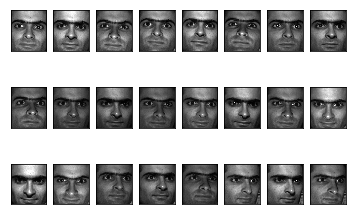

Images of all the subjects


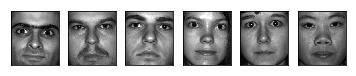

In [4]:
# Create a YaleDatasetLoader object
Dataset = YaleDatasetLoader('./Training Images/Training Images','./Training Images/Training Images.txt')

# prepare images and labels
Dataset.getImagesLabels()
# run the demo
Dataset.demo()

### Calc eigenfaces and the mean face

Create an 𝑁×𝐷 feature matrix 𝐴

    𝑁 denotes the number of training images

    𝐷 denotes the size of each feature vector (each feature vector is constructed by converting the training images into 1×𝐷 vectors)

In [5]:
# Read the size of the images
height,width = Dataset.data[0]["img"].shape
# feature size
D = height * width
# initialize and fill the feature matrix
A = np.empty((Dataset.N, D), dtype=np.float64)
for i in range(Dataset.N):
    A[i,:] = np.float64(Dataset.data[i]["img"]).reshape((1,-1))

Compute the 1×𝐷 mean face, as the average of all training faces

In [6]:
# Compute the mean face
meanFace = np.mean(A, axis=0)

Subtract the mean face from each feature vector and update the feature matrix 𝐴

In [7]:
# Subtract the mean face from each feature vector
A = A - meanFace  

Calculate the 𝑁×𝑁 covariance matrix 𝐶′=𝐴∗𝐴^𝑇 (𝐴^𝑇 is A transposed)

In [8]:
# Calc the covariance matrix
C = A.dot(A.transpose())

Find all the 1×𝑁 eigen vectors 𝑣′ and the eigen values of the covariance matrix 𝐶′

Compute each 1×𝐷 Eigenface 𝑣=𝑣′∗𝐴

Normalize the L2 norm of each Eigenface 𝑣

In [9]:
# Find the eigenvectors/eigenvalues of C
retval, eigenvalues, eigenvectors = cv2.eigen(C)

# Compute each 1×𝐷 Eigenface 𝑣
v = eigenvectors.dot(A)

# Normalize the L2 norm of each Eigenface 𝑣
for i in range(v.shape[0]):
    v[i,:] = cv2.normalize(v[i,:],0,1,cv2.NORM_L2).flatten()

### Display the meanface and the first 24 eigenfaces

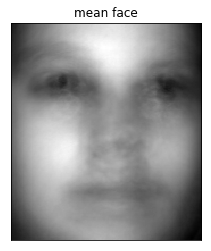

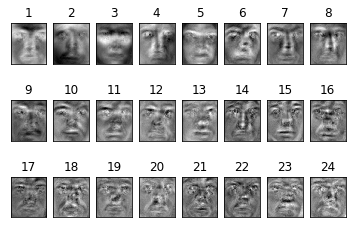

In [10]:
# Reshape the mean face to a 2D matrix and display
plt.imshow(meanFace.reshape((height,width)), cmap='gray'),plt.title("mean face")
plt.xticks([]), plt.yticks([])
plt.show()

# Reshape each eigenface to a 2D matrix and display
for i in range(24):
    plt.subplot(3,8,i+1),plt.imshow(v[i,:].reshape((height,width)), cmap='gray'), plt.title(str(i+1))
    plt.xticks([]), plt.yticks([])
plt.show()

### Compute the reconstruction error

One way to evaluate the performance of Eigenfaces is to project a face image onto the Eigen space and then reconstruct the face image by projecting back from the Eigen space. Note that this procedure is usually done using a subset of Eigenfaces (the best K eigenfaces) instead of using all of them.

Given K, do for all training images:

    1. Reshape the image into a 1×𝐷 vector

    2. Project the image to the Eigen space using the best K eigenfaces

    3. Reconstruct the image by projecting back to the pixel space

    4. Calculate the mean square error between the image and its reconstructed version

5.Calculate the mean error over all the training images

To project a 1×𝐷 input image into the 𝐾-dimensional Eigen space:   output = (input - meanFace) * eigenFaces^𝑇

To project a 1×𝐾 input image in the eigenspace back to the 𝐷-dimensional pixel space:  output = input * eigenFaces + meanFace

[[-0.0011004  -0.00102898 -0.00079412 ...,  0.00099465  0.00105904
   0.00091617]]
[[ -1.10039540e-03  -1.02897707e-03  -7.94123233e-04 ...,   9.94647381e-04
    1.05903528e-03   9.16168428e-04]
 [ -1.60845583e-03  -1.27318230e-03  -1.20710915e-03 ...,   2.07524337e-03
    1.93466539e-03   2.02724748e-03]
 [  7.39747215e-05   1.50495247e-04  -6.25026906e-06 ...,  -6.27206908e-03
   -6.27068131e-03  -5.43919539e-03]
 [  2.11501089e-03   2.31609202e-03   2.77459877e-03 ...,  -7.89733889e-04
   -9.92290576e-04  -1.34622371e-03]
 [ -9.08085139e-03  -9.90205204e-03  -1.04213723e-02 ...,   1.18019672e-03
    1.82488365e-03   1.79790540e-03]]
[[ -1.10039540e-03  -1.02897707e-03  -7.94123233e-04 ...,   9.94647381e-04
    1.05903528e-03   9.16168428e-04]
 [ -1.60845583e-03  -1.27318230e-03  -1.20710915e-03 ...,   2.07524337e-03
    1.93466539e-03   2.02724748e-03]
 [  7.39747215e-05   1.50495247e-04  -6.25026906e-06 ...,  -6.27206908e-03
   -6.27068131e-03  -5.43919539e-03]
 ..., 
 [ -8.1446950

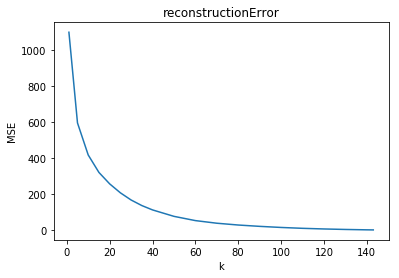

In [11]:
K = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 143])

# Loop over different values for K
reconstructionError = np.zeros(K.shape[0])
for k in range(K.shape[0]):
    # Use a subset of eigenfaces
    eigenFaces = v[0:K[k],:]
    print (eigenFaces)
    # loop over all training images
    MSE = np.zeros(Dataset.N)
    for i in range(Dataset.N):       
        # Reshape the image into a 1×𝐷 vector
        img = np.float64(Dataset.data[i]["img"]).reshape((1,-1))
        # Project the image to the Eigen space
        projection = (img - meanFace).dot(eigenFaces.transpose()) 
        # Reconstruct the image by projecting back to the pixel space
        recontructed = projection.dot(eigenFaces) + meanFace
        # Calc the MSE
        MSE[i] = np.mean((img - recontructed)*(img - recontructed))
    reconstructionError[k] = np.mean(MSE)
    
# Plot the result
plt.plot(K,reconstructionError)
plt.title('reconstructionError'),plt.xlabel('k'),plt.ylabel('MSE')
plt.show()